In [66]:
import pandas as pd
import numpy as np
df = pd.read_csv("./MLC_SP23/clean_data/merged_data_v3.csv", low_memory=False, index_col=[0])

In [67]:
df.head()

,bbl,total_units_19,year_built,ejectment_count,possession_count,eviction_count,aleration_count,altered_lessthan5yrs,altered_morethan5yrs,classanet_avg,...,boro_2,boro_3,boro_4,boro_5,rs_share_diff_new,hh_inc_avg_19_log1,pop_race_asian_pct_19_log1,pop_race_black_pct_19_log1,pop16_unemp_pct_19_log1,pop_mobile1_diff_state_pct_19_log1
0,1000780047,483,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0.0,12.276639,0.150551,0.018246,0.035008,0.074674
1,1001350019,4,1915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0.0,12.897523,0.096864,0.055298,0.002253,0.014341
2,1001620013,20,1915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1.0,10.973689,0.461379,0.096629,0.037102,0.008935
3,1001630024,16,1915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0.0,10.973689,0.461379,0.096629,0.037102,0.008935
4,1001630033,11,1915,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0.0,10.973689,0.461379,0.096629,0.037102,0.008935


In [75]:
df.columns

Index(['bbl', 'total_units_19', 'year_built', 'ejectment_count',
       'possession_count', 'eviction_count', 'aleration_count',
       'altered_lessthan5yrs', 'altered_morethan5yrs', 'classanet_avg',
       'enlargement_count', 'hpd_calls_2017', 'hpd_calls_2018',
       'hpd_calls_2019', 'dob_calls_2017', 'dob_calls_2018', 'dob_calls_2019',
       'b_violations_2017', 'b_violations_2018', 'b_violations_2019',
       'c_violations_2017', 'c_violations_2018', 'c_violations_2019',
       'cases_2017', 'cases_2018', 'cases_2019', 'Heat and Hot Water_2017',
       'Heat and Hot Water_2018', 'Heat and Hot Water_2019',
       'Tenant Action_2017', 'Tenant Action_2018', 'Tenant Action_2019',
       'CONH_2017', 'CONH_2018', 'CONH_2019', 'Tenant Action/Harrassment_2017',
       'Tenant Action/Harrassment_2018', 'Tenant Action/Harrassment_2019',
       'hh_inc_own_med_19', 'own_cost_mort_med_19', 'own_burden_mort_med_19',
       'rent_contract_med_19', 'rent_burden_med_19', 'pop_65p_pct_19',
  

# Train-test split

In [68]:
X = df.drop(['rs_share_diff_new', 'bbl'], axis = 1)
y = df['rs_share_diff_new']

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [70]:
# Baseline accuracy
1 - y_train.mean()

0.6598096933187294

# Random Forest

In [71]:
# Fit model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time

scoring = {'Accuracy':'accuracy',
           'F1 Score':'f1',
           'Precision':'precision',
           'Recall':'recall',
           'AUC':'roc_auc'
}

param_grid = {'max_depth':[2, 4, 6],
              'n_estimators': [100, 200, 300]
}

start = time.time()

rf = RandomForestClassifier(random_state = 1)
gr = GridSearchCV(rf, param_grid = param_grid, scoring = scoring, refit = "AUC", cv = 4)
fit = gr.fit(X_train, y_train)

end = time.time()

print("Running grid search took", end - start, "seconds") # time in seconds to run grid search
print()
print(fit.best_params_)
print(fit.best_score_)

Running grid search took 90.43090987205505 seconds

{'max_depth': 6, 'n_estimators': 200}
0.7893994468840426


In [72]:
# get all cv metrics for best model

best_params_index = fit.cv_results_['rank_test_AUC'][0] - 1
print("Best model AUC:", fit.cv_results_['mean_test_AUC'][best_params_index])
print("Best model accuracy:", fit.cv_results_['mean_test_Accuracy'][best_params_index])
print("Best model F1 score:", fit.cv_results_['mean_test_F1 Score'][best_params_index])
print("Best model precision:", fit.cv_results_['mean_test_Precision'][best_params_index])
print("Best model recall:", fit.cv_results_['mean_test_Recall'][best_params_index])

Best model AUC: 0.7886352383486499
Best model accuracy: 0.8212965498357063
Best model F1 score: 0.6656756641290565
Best model precision: 0.9155302248079528
Best model recall: 0.5229909651143576


In [73]:
# score model on test set
from sklearn import metrics

y_hat_test = fit.predict(X_test)
auc = metrics.roc_auc_score(y_test, y_hat_test)
acc = metrics.accuracy_score(y_test, y_hat_test)
f1 = metrics.f1_score(y_test, y_hat_test)
prec = metrics.precision_score(y_test, y_hat_test)
rec = metrics.recall_score(y_test, y_hat_test)

print("Out of sample AUC is:", auc)
print("Out of sample accuracy is:", acc)
print("Out of sample F1 score is:", f1)
print("Out of sample precision is:", prec)
print("Out of sample recall is:", rec)

Out of sample AUC is: 0.7470466085086686
Out of sample accuracy is: 0.8223636923708799
Out of sample F1 score is: 0.661845191555903
Out of sample precision is: 0.9166215484569572
Out of sample recall is: 0.517895380850413


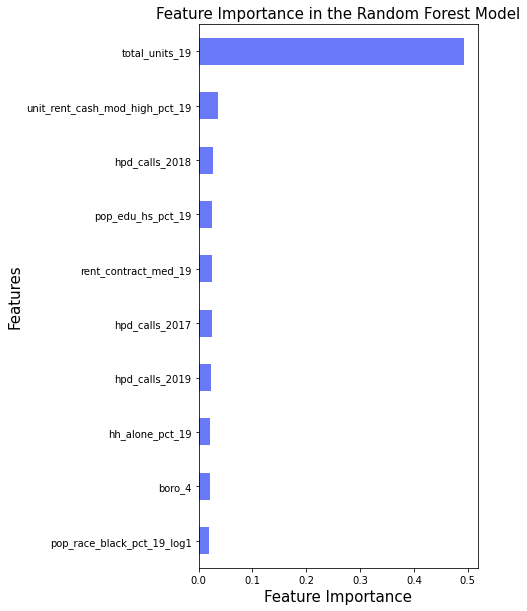

In [74]:
# get feature importance
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

plt.figure(figsize=(5,10))
importances = pd.Series(fit.best_estimator_.feature_importances_, X_train.columns)
importances.sort_values().tail(10).plot.barh(color = '#6a79f7')
plt.title('Feature Importance in the Random Forest Model',fontsize=15)
plt.xlabel('Feature Importance',fontsize = 15)
plt.ylabel('Features',fontsize = 15)
plt.show()

# Parameter tuning history

In [ ]:
# Initial run: max_depth = 6, n_estimators = 200
# 90 seconds

#Out of sample AUC is: 0.7470466085086686
#Out of sample accuracy is: 0.8223636923708799
#Out of sample F1 score is: 0.661845191555903
#Out of sample precision is: 0.9166215484569572
#Out of sample recall is: 0.517895380850413

In [45]:
# Slight improvement: max_depth = 6, n_estimators = 400
# 248 seconds

#Out of sample AUC is: 0.7534245212534708
#Out of sample accuracy is: 0.8267296243071238
#Out of sample F1 score is: 0.6724873884361661
#Out of sample precision is: 0.911625460284061
#Out of sample recall is: 0.532739010144482

In [ ]:
# Another slight improvement: max_depth = 10, n_estimators = 350
# 432 seconds

#Out of sample AUC is: 0.7572647120144724
#Out of sample accuracy is: 0.828679942516937
#Out of sample F1 score is: 0.6788531845295364
#Out of sample precision is: 0.9074074074074074
#Out of sample recall is: 0.5422686750691669

In [ ]:
# drop total units

#Out of sample AUC is: 0.6607530670859816
#Out of sample accuracy is: 0.7484089509340998
#Out of sample F1 score is: 0.5130141068944963
#Out of sample precision is: 0.7252808988764045
#Out of sample recall is: 0.3968644328312327